# Initial Data Exploration - Snohomish River at Monroe

In [1]:
# USGS site 12150800

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
import warnings
import re
warnings.filterwarnings("ignore")

In [2]:
# set up plotting
plt.style.use('default')
sns.set_palette('husl')

Initial data exploration for flood warning frequency analysis. Focus location is Snohomish River at Monroe, WA.

In [3]:
# USGS data collection via API. reference: https://api.waterdata.usgs.gov/

def get_usgs_data(site_id, parameter_code, start_date, end_date):
    """
    Download USGS data using their REST API. 

    params:
        site_id (str):           USGS site ID
        parameter_code (str):    parameter code (e.g., '00065' for stage, '00060' for discharge)
        start_date (str):        start date in 'YYYY-MM-DD' format
        end_date (str):          end date in 'YYYY-MM-DD' format

    output:
        df (DataFrame):          pandas DataFrame with time series data
        param_name (str):        name of the parameter
        param_unit (str):        unit of the parameter
    """

    base_url = "https://waterservices.usgs.gov/nwis/dv/"

    params = {
        'format': 'json',
        'sites': site_id,
        'parameterCd': parameter_code,
        'startDT': start_date,
        'endDT': end_date,
        'siteStatus': 'all'
    }

    print(f"Requesting data for parameter {parameter_code} from {start_date} to {end_date}")

    try:
        response = requests.get(base_url, params = params)
        response.raise_for_status() # raise an error for bad responses
        data = response.json() 

        # extract time series data
        # if 'value' in data and 'timeSeries' in data['value']:
        if 'value' in data and 'timeSeries' in data['value'] and len(data['value']['timeSeries']) > 0:
            if len(data['value']['timeSeries']) > 0:
                time_series = data['value']['timeSeries'][0]['values'][0]['value']

                # convert to dataframe
                df = pd.DataFrame(time_series)
                df['dateTime'] = pd.to_datetime(df['dateTime'])
                df['value'] = pd.to_numeric(df['value'], errors = 'coerce')
                df.set_index('dateTime', inplace = True)

                # get param info for labeling
                param_info = data['value']['timeSeries'][0]['variable']
                param_name = param_info['variableName']
                param_unit = param_info['unit']['unitCode']

                # debugging statements
                print(f"Successfully downloaded {len(df)} records of {param_name}")
                print(f"Units: {param_unit}")

                return df, param_name, param_unit
            else:
                print("No time series data found for the specified parameters.")
                return None, None, None
        else:
            print("No data found for the specified parameters.")
            return None, None, None

    except requests.exceptions.RequestException as e: # debug to figure out what's wrong
        print(f"Error fetching data: {e}")
        return None, None, None

### Site Data Gathering

In [11]:
def get_site_info(site_id):
    """
    Get site information including name and location from USGS API.

    @site_id (str)     :   USGS site ID

    output:
        site_name (str):   name of the site
        
    """
    
##### DOENST WORK YET #######

# define our site and date range
site_id = '12150800'   # Snohomish river at Monroe -- 12150800, 06902000
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')  # Last 5 years

print(f"\nCollecting data from {start_date} to {end_date}")

# download stage data
stage_data, stage_name, stage_unit = get_usgs_data(site_id, '00065', start_date, end_date)

# download discharge data
discharge_data, discharge_name, discharge_unit = get_usgs_data(site_id, '00060', start_date, end_date)




Requesting data for parameter 00065 from 2020-07-08 to 2025-07-07
Successfully downloaded 1819 records of Gage height, ft
Units: ft
Requesting data for parameter 00060 from 2020-07-08 to 2025-07-07
Successfully downloaded 1825 records of Streamflow, ft&#179;/s
Units: ft3/s


In [12]:
import time

def process_sites(file, start_date, end_date):
    """
    Process all sites from the site codes file and create a summary DataFrame.
    
    params:
        file (str): Path to file containing site codes (one per line)
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        
    output:
        summary_df (DataFrame): Summary DataFrame with all sites
    """

    # read site codes from file
    try:
        with open(file, 'r') as f:
            site_codes = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Could not find file {file}")
        return None
    
    print(f"Processing {len(site_codes)} sites...")

    # store results
    results = []
    
    for i, site_id in enumerate(site_codes):
        print(f"\n--- Processing site {i+1}/{len(site_codes)}: {site_id} ---")
        
        # Initialize result dictionary
        result = {
            'site_id': site_id,
        }
        
        # get stage data
        print(f"Getting stage data for {site_id}...")
        print(start_date + " to " + end_date)
        stage_data, stage_name, stage_unit = get_usgs_data(site_id, '00065', start_date, end_date)
        
        # if stage_data is not None and not stage_data.empty:
        #     # calculate stage statistics
        #     result.update({
        #         'stage_param_name': stage_name,
        #         'stage_unit': stage_unit,
        #         'stage_count': len(stage_data),
        #         'stage_mean': stage_data['value'].mean(),
        #         'stage_median': stage_data['value'].median(),
        #         'stage_min': stage_data['value'].min(),
        #         'stage_max': stage_data['value'].max(),
        #         'stage_std': stage_data['value'].std(),
        #         'stage_latest': stage_data['value'].iloc[-1] if not stage_data.empty else None,
        #         'stage_latest_date': stage_data.index[-1] if not stage_data.empty else None
        #     })
        # else:
        #     result.update({
        #         'stage_param_name': None,
        #         'stage_unit': None,
        #         'stage_count': 0,
        #         'stage_mean': None,
        #         'stage_median': None,
        #         'stage_min': None,
        #         'stage_max': None,
        #         'stage_std': None,
        #         'stage_latest': None,
        #         'stage_latest_date': None
        #     })
        
        # # no breaking API
        # time.sleep(0.5)

        # # Get discharge data
        # print(f"Getting discharge data for {site_id}...")
        # discharge_data, discharge_name, discharge_unit = get_usgs_data(site_id, '00060', start_date, end_date)
        
        # if discharge_data is not None and not discharge_data.empty:
        #     # calculate discharge statistics
        #     result.update({
        #         'discharge_param_name': discharge_name,
        #         'discharge_unit': discharge_unit,
        #         'discharge_count': len(discharge_data),
        #         'discharge_mean': discharge_data['value'].mean(),
        #         'discharge_median': discharge_data['value'].median(),
        #         'discharge_min': discharge_data['value'].min(),
        #         'discharge_max': discharge_data['value'].max(),
        #         'discharge_std': discharge_data['value'].std(),
        #         'discharge_latest': discharge_data['value'].iloc[-1] if not discharge_data.empty else None,
        #         'discharge_latest_date': discharge_data.index[-1] if not discharge_data.empty else None
        #     })
        # else:
        #     result.update({
        #         'discharge_param_name': None,
        #         'discharge_unit': None,
        #         'discharge_count': 0,
        #         'discharge_mean': None,
        #         'discharge_median': None,
        #         'discharge_min': None,
        #         'discharge_max': None,
        #         'discharge_std': None,
        #         'discharge_latest': None,
        #         'discharge_latest_date': None
        #     })
        
        # results.append(result)
        
        # # add another small delay
        # time.sleep(0.5)

        print(f"Completed {site_id}: Stage records: {result['stage_count']}, Discharge records: {result['discharge_count']}")

    summary_df = pd.DataFrame(results)
    
    print(f"\n=== PROCESSING COMPLETE ===")
    print(f"Processed {len(site_codes)} sites")
    print(f"Sites with stage data: {summary_df['stage_count'].gt(0).sum()}")
    print(f"Sites with discharge data: {summary_df['discharge_count'].gt(0).sum()}")
    
    return summary_df


# define date range (last 5 years)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')

print(f"Date range: {start_date} to {end_date}")

site_codes_file = '../data/raw_data/processed_data/site_codes.txt'  # Update this path if needed
summary_df = process_sites(site_codes_file, start_date, end_date)
    
    

Date range: 2020-07-08 to 2025-07-07
Error: Could not find file ../data/raw_data/processed_data/site_codes.txt


**See what the individual dataframes look like**

In [13]:
stage_data
# discharge_data

,value,qualifiers
dateTime,,
2020-07-08,2.94,[A]
2020-07-09,2.81,[A]
2020-07-10,2.70,[A]
2020-07-11,2.65,[A]
2020-07-12,2.68,[A]
...,...,...
2025-07-02,1.40,[P]
2025-07-03,1.30,[P]
2025-07-04,1.20,[P]


**See what the combined dataframe looks like**


Data Summary:
Stage data: 1819 records
Discharge data: 1825 records
Combined dataset: 1819 records with both stage and discharge


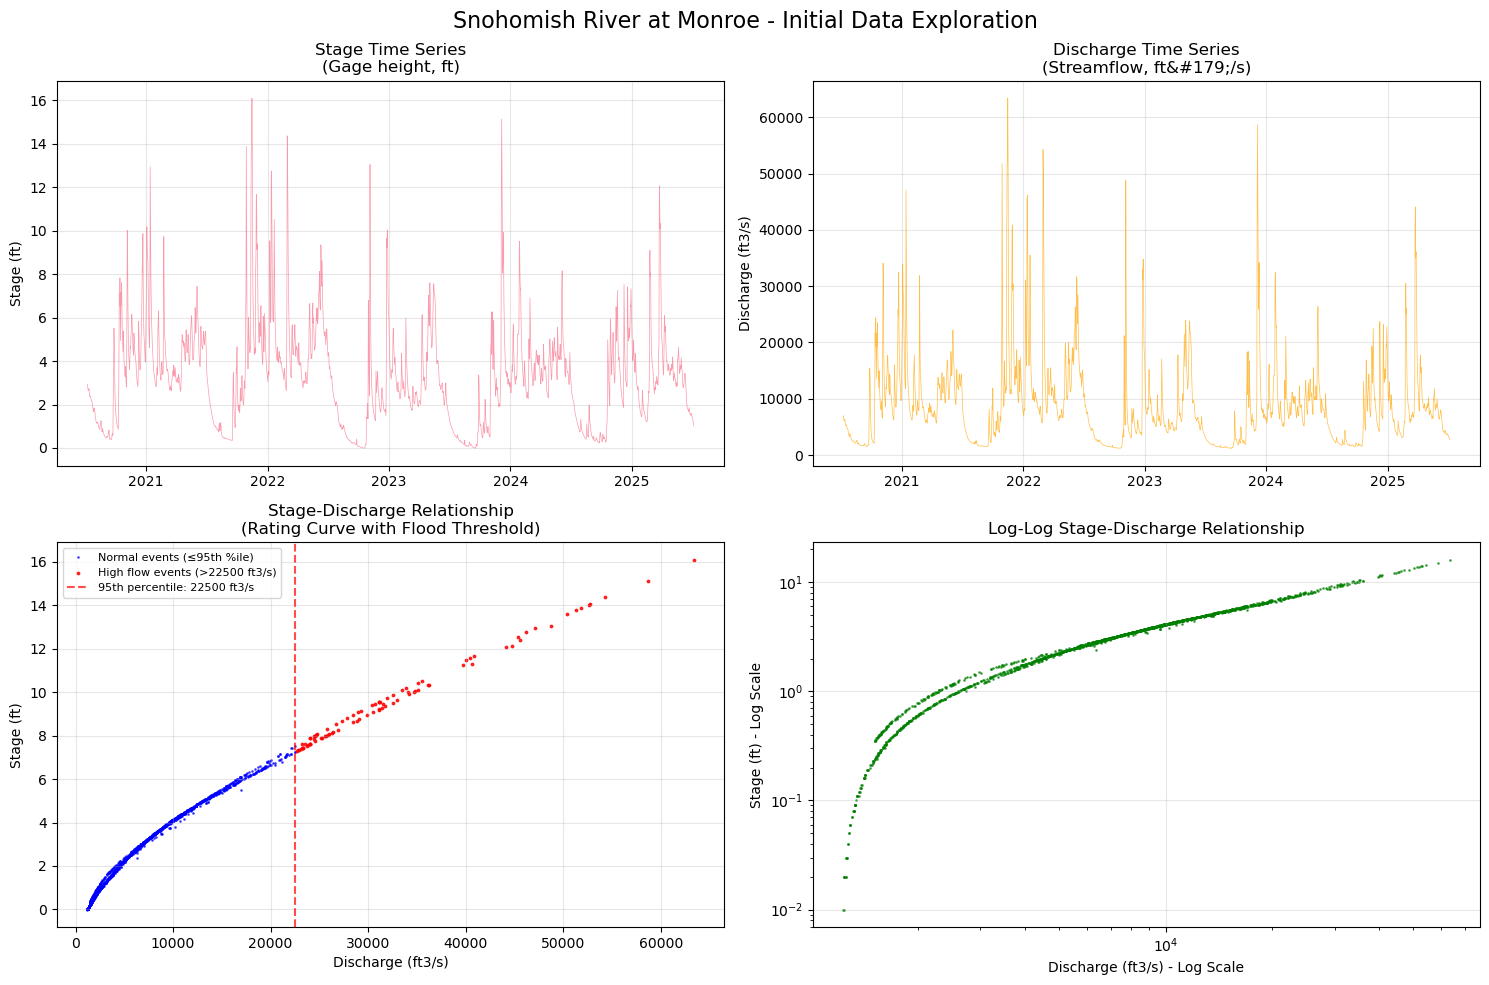

,qualifiers_stage,value_stage,qualifiers_discharge,value_discharge
dateTime,,,,
2020-07-08,2.94,[A],6980,[A]
2020-07-09,2.81,[A],6580,[A]
2020-07-10,2.70,[A],6260,[A]
2020-07-11,2.65,[A],6110,[A]
2020-07-12,2.68,[A],6200,[A]
...,...,...,...,...
2025-07-02,1.40,[P],3440,[P]
2025-07-03,1.30,[P],3250,[P]
2025-07-04,1.20,[P],3070,[P]


In [14]:
# Combine datasets and create visualizations
# part of data exploration and visualization

if stage_data is not None and discharge_data is not None: # error handling
    print(f"\nData Summary:")
    print(f"Stage data: {len(stage_data)} records")
    print(f"Discharge data: {len(discharge_data)} records")

    # combine datasets
    combined_data = pd.merge(stage_data, discharge_data, left_index=True, right_index=True, 
                           suffixes=('_stage', '_discharge'))
    combined_data.columns = ['qualifiers_stage', 'value_stage', 'qualifiers_discharge', 'value_discharge']

    print(f"Combined dataset: {len(combined_data)} records with both stage and discharge")

    total_days = len(combined_data)
    years_of_data = total_days / 365.25

    # Calculate 95th percentile for high flow analysis
    discharge_95th = combined_data['qualifiers_discharge'].quantile(0.95)
    high_flow_events = combined_data[combined_data['qualifiers_discharge'] > discharge_95th]
    

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Snohomish River at Monroe - Initial Data Exploration', fontsize=16)

    # Time series plots
    axes[0, 0].plot(combined_data.index, combined_data['qualifiers_stage'], alpha=0.7, linewidth=0.5)
    axes[0, 0].set_title(f'Stage Time Series\n({stage_name})')
    axes[0, 0].set_ylabel(f'Stage ({stage_unit})')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(combined_data.index, combined_data['qualifiers_discharge'], alpha=0.7, linewidth=0.5, color='orange')
    axes[0, 1].set_title(f'Discharge Time Series\n({discharge_name})')
    axes[0, 1].set_ylabel(f'Discharge ({discharge_unit})')
    axes[0, 1].grid(True, alpha=0.3)

    # Stage-discharge relationship (the key relationship!)
    normal_events = combined_data[combined_data['qualifiers_discharge'] <= discharge_95th]


    axes[1, 0].scatter(normal_events['qualifiers_discharge'], normal_events['qualifiers_stage'], 
                      alpha=0.6, s=1, color='blue', label='Normal events (≤95th %ile)')
    
    # Plot high flow events in red
    axes[1, 0].scatter(high_flow_events['qualifiers_discharge'], high_flow_events['qualifiers_stage'], 
                      alpha=0.8, s=3, color='red', label=f'High flow events (>{discharge_95th:.0f} {discharge_unit})')
    
    # Add vertical line at 95th percentile
    axes[1, 0].axvline(x=discharge_95th, color='red', linestyle='--', alpha=0.7, 
                      label=f'95th percentile: {discharge_95th:.0f} {discharge_unit}')
    axes[1, 0].set_xlabel(f'Discharge ({discharge_unit})')
    axes[1, 0].set_ylabel(f'Stage ({stage_unit})')
    axes[1, 0].set_title('Stage-Discharge Relationship\n(Rating Curve with Flood Threshold)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend(fontsize=8)



    # Log-log relationship (often more linear)
    valid_data = combined_data[(combined_data['qualifiers_discharge'] > 0) & (combined_data['qualifiers_stage'] > 0)]
    axes[1, 1].scatter(valid_data['qualifiers_discharge'], valid_data['qualifiers_stage'], 
                        alpha=0.6, s=1, color='green')
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_xlabel(f'Discharge ({discharge_unit}) - Log Scale')
    axes[1, 1].set_ylabel(f'Stage ({stage_unit}) - Log Scale')
    axes[1, 1].set_title('Log-Log Stage-Discharge Relationship')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Could not retrieve both stage and discharge data. Check the site ID and date range.")

combined_data

## Scraping NOAA/NWS flood level data

In [19]:
from bs4 import BeautifulSoup
from time import sleep
import json
import logging

# Set up logging to track progress and errors
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def get_flood_data_for_site(site_code):
    """
    Fetch flood level data for a single site code.
    Returns a dictionary with site data or None if failed.
    """
    try:
        url = f'https://api.water.noaa.gov/nwps/v1/gauges/{site_code}'
        
        # Make API request with timeout
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        
        data = response.json()
        
        # Check if flood data exists
        if 'flood' not in data or 'categories' not in data['flood']:
            logger.warning(f"No flood categories found for site {site_code}")
            return None
            
        # Extract flood thresholds
        categories = data['flood']['categories']
        thresholds = {
            'major_stage': categories.get('major', {}).get('stage'),
            'mod_stage': categories.get('moderate', {}).get('stage'),
            'minor_stage': categories.get('minor', {}).get('stage'),
            'action_stage': categories.get('action', {}).get('stage'),
        }
        
        # Get historic crests
        historic_crests = data.get('flood', {}).get('crests', {}).get('historic', [])
        
        # Count how many times each threshold was reached
        counts = {'major': 0, 'moderate': 0, 'minor': 0, 'action': 0}
        
        for crest in historic_crests:
            stage = crest.get('stage', 0)
            if stage and thresholds['major_stage'] and stage >= thresholds['major_stage']:
                counts['major'] += 1
            if stage and thresholds['mod_stage'] and stage >= thresholds['mod_stage']:
                counts['moderate'] += 1
            if stage and thresholds['minor_stage'] and stage >= thresholds['minor_stage']:
                counts['minor'] += 1
            if stage and thresholds['action_stage'] and stage >= thresholds['action_stage']:
                counts['action'] += 1
        
        # Create row data
        row = {
            'site_code': site_code,
            'usgsId': data.get('usgsId'),
            'siteName': data.get('name'),
            'state': data.get('state', {}).get('name') if data.get('state') else None,
            'latitude': data.get('latitude'),
            'longitude': data.get('longitude'),
            
            # Flood thresholds
            'major_stage': thresholds['major_stage'],
            'mod_stage': thresholds['mod_stage'],
            'minor_stage': thresholds['minor_stage'],
            'action_stage': thresholds['action_stage'],
            
            # Historical flood event counts
            'hist_major': counts['major'],
            'hist_mod': counts['moderate'],
            'hist_minor': counts['minor'],
            'action_trig': counts['action'],
            
            # Additional metadata
            'total_historic_crests': len(historic_crests),
            'has_usgs_id': bool(data.get('usgsId')),
        }
        
        return row
        
    except requests.exceptions.RequestException as e:
        logger.error(f"Request failed for site {site_code}: {e}")
        return None
    except json.JSONDecodeError as e:
        logger.error(f"JSON decode error for site {site_code}: {e}")
        return None
    except KeyError as e:
        logger.error(f"Missing expected data for site {site_code}: {e}")
        return None
    except Exception as e:
        logger.error(f"Unexpected error for site {site_code}: {e}")
        return None

def scrape_all_sites(filename):
    """
    Read site codes from file and scrape flood data for all sites.
    Returns a pandas DataFrame with results.
    """
    try:
        with open(filename, 'r') as f:
            site_codes = [line.strip() for line in f if line.strip()]
        logger.info(f"Found {len(site_codes)} site codes in {filename}")
    except FileNotFoundError:
        logger.error(f"File {filename} not found")
        return pd.DataFrame()
    
    # Initialize list to store results
    all_data = []
    successful_sites = 0
    failed_sites = 0
    
    # Process each site code
    for i, site_code in enumerate(site_codes, 1):
        logger.info(f"Processing site {i}/{len(site_codes)}: {site_code}")
        
        # Get data for this site
        site_data = get_flood_data_for_site(site_code)
        
        if site_data:
            all_data.append(site_data)
            successful_sites += 1
            logger.info(f"✓ Successfully processed {site_code}")
        else:
            failed_sites += 1
            logger.warning(f"✗ Failed to process {site_code}")
        
        # Add small delay to be respectful to the API
        sleep(0.1)
        
        # Progress update every 50 sites
        if i % 50 == 0:
            logger.info(f"Progress: {i}/{len(site_codes)} sites processed. "
                       f"Success: {successful_sites}, Failed: {failed_sites}")
    
    # Create DataFrame
    if all_data:
        df = pd.DataFrame(all_data)
        df.set_index('site_code', inplace=True)
        
        logger.info(f"Scraping complete! Successfully processed {successful_sites} sites, "
                   f"failed on {failed_sites} sites")
        logger.info(f"Final DataFrame shape: {df.shape}")
        
        return df
    else:
        logger.error("No data was successfully retrieved for any sites")
        return pd.DataFrame()
    
flood_df = scrape_all_sites("../data/raw_data/processed_data/site_codes_all.txt")

# response = requests.get(f'https://api.water.noaa.gov/nwps/v1/gauges/{site_code}')
# response.raise_for_status() # good practice to check for errors
# data = response.json()
# # print(data) # very long

# # with open(f"flood_data_{site_code}.json", "w") as f:
# #     json.dump(data, f, indent=4)

# # df rows

# # flood thresholds
# thresholds = {
#     'major_stage' : data['flood']['categories']['major']['stage'],
#     'mod_stage'   : data['flood']['categories']['moderate']['stage'],
#     'minor_stage' : data['flood']['categories']['minor']['stage'],
#     'action_stage': data['flood']['categories']['action']['stage'],
# }
    
# historic_crests = data.get('flood', {}).get('crests', {}).get('historic', [])

# # count how many times each threshold was reached
# counts = {'major': 0, 'moderate': 0, 'minor': 0, 'action': 0}

# for crest in historic_crests:
#     stage = crest.get('stage', 0)
#     if stage >= thresholds['major_stage']:
#         counts['major'] += 1
#     if stage >= thresholds['mod_stage']:
#         counts['moderate'] += 1
#     if stage >= thresholds['minor_stage']:
#         counts['minor'] += 1
#     if stage >= thresholds['action_stage']:
#         counts['action'] += 1


# row = {
#     'usgsId'      : data.get('usgsId'),
#     'siteName'    : data.get('name'),
#     'state'       : data['state']['name'],
#     'latitude'    : data.get('latitude'),
#     'longitude'   : data.get('longitude'),
#     #thresholds
#     'major_stage' : thresholds['major_stage'],
#     'mod_stage'   : thresholds['mod_stage'],
#     'minor_stage' : thresholds['minor_stage'],
#     'action_stage': thresholds['action_stage'],


#     # historical flood events
#     'hist_major'  : counts['major'],
#     'hist_mod'    : counts['moderate'],
#     'hist_minor'  : counts['minor'],
#     'action_trig' : counts['action'],
# }

# # make DataFrame
# site_code = data.get('lid')
# df = pd.DataFrame([row], index=[site_code])

# df


2025-07-07 16:12:24,451 - INFO - Found 567 site codes in ../data/raw_data/processed_data/site_codes_all.txt
2025-07-07 16:12:24,452 - INFO - Processing site 1/567: 12010000
2025-07-07 16:12:24,958 - INFO - ✓ Successfully processed 12010000
2025-07-07 16:12:25,059 - INFO - Processing site 2/567: 12013500
2025-07-07 16:12:25,465 - INFO - ✓ Successfully processed 12013500
2025-07-07 16:12:25,567 - INFO - Processing site 3/567: 12017000
2025-07-07 16:12:25,867 - ERROR - Request failed for site 12017000: 404 Client Error: Not Found for url: https://api.water.noaa.gov/nwps/v1/gauges/12017000
2025-07-07 16:12:25,868 - WARNING - ✗ Failed to process 12017000
2025-07-07 16:12:25,969 - INFO - Processing site 4/567: 12019310
2025-07-07 16:12:26,249 - ERROR - Request failed for site 12019310: 404 Client Error: Not Found for url: https://api.water.noaa.gov/nwps/v1/gauges/12019310
2025-07-07 16:12:26,251 - WARNING - ✗ Failed to process 12019310
2025-07-07 16:12:26,352 - INFO - Processing site 5/567: 

In [ ]:
# raw processed csv
output_filename = 'flood_levels_all_sites.csv'
flood_df.to_csv(output_filename)

In [22]:
# validate flood data -- some sites have no flood warning thresholds
threshold_columns = ['major_stage', 'mod_stage', 'minor_stage', 'action_stage']

missing_cols = [col for col in threshold_columns if col not in flood_df.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
    

def check_valid_thresholds(row):
        """
        Check if any of the four flood stage thresholds has a valid value (not -9999).
        Returns 'yes' if at least one valid threshold exists, 'no_datum' otherwise.
        """
        for col in threshold_columns:
            value = row[col]
            # Check if value exists, is not NaN, and is not -9999
            if pd.notna(value) and value != -9999:
                return 'yes'
        return 'no_datum'

flood_df['valid'] = flood_df.apply(check_valid_thresholds, axis=1)

# Print summary statistics
valid_counts = flood_df['valid'].value_counts()
print(f"\nValidation Results:")
print(f"Sites with valid flood thresholds: {valid_counts.get('yes', 0)}")
print(f"Sites without valid flood thresholds: {valid_counts.get('no_datum', 0)}")
print(f"Percentage with valid data: {(valid_counts.get('yes', 0) / len(flood_df) * 100):.1f}%")
    
flood_df

output_filename = 'flood_levels_all_sites_valid.csv'
flood_df.to_csv(output_filename)


Validation Results:
Sites with valid flood thresholds: 60
Sites without valid flood thresholds: 125
Percentage with valid data: 32.4%


In [ ]:
from bs4 import BeautifulSoup
import json


site_code = 'MROW1' # Missouri (SNZM7)
url = f"https://water.noaa.gov/gauges/{site_code}"

print(f"Scraping flood levels from: {url}")

page = requests.get(url)
soup = BeautifulSoup(page.text, 'html')

# print(soup.prettify())

response = requests.get(f'https://api.water.noaa.gov/nwps/v1/gauges/{site_code}')
response.raise_for_status() # good practice to check for errors
data = response.json()
print(data)

with open(f"flood_data_{site_code}.json", "w") as f:
    json.dump(data, f, indent=4)



# <table class="categories-table uk-table table-xsmall uk-table-divider svelte-17s0s5l">

# soup.find('table')


def scrape_nws_flood_levels(site_code):
    """
    Scrape flood warning levels from NOAA/NWS website
    
    params:
        site_code: NWS site code (e.g., 'MROW1' for Monroe)
    
    output:
        Dictionary with flood level information
    """

    url = f"https://water.noaa.gov/gauges/{site_code}"
    

    print(f"Scraping flood levels from: {url}")

    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')

    print(soup)
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # look for flood level information
        flood_levels = {}
        
        # try to find flood level tables or sections
        table = soup.find('table', class_='categories-table') # uk-table

        if table:
            rows = table.find_all('tr')[1:]  # skip header row
            for row in rows:
                cols = row.find_all('td')
                if len(cols) >= 3:
                    category = cols[1].get_text(strip=True)
                    stage = cols[2].get_text(strip=True)
                    flood_levels[category] = stage
        else:
            print("Flood levels table not found!")

    #     if table:
    #         print("Found flood levels table!")
            
    #         # Find all rows in the table
    #         rows = table.find_all('tr', class_='font-size-13')
            
    #         for row in rows:
    #             # Find the category cell (flood level name)
    #             category_cell = row.find('td', class_=lambda x: x and 'category' in x and 'uk-text-bold' in x)
                
    #             # Find the value cell (stage in feet)
    #             value_cells = row.find_all('td', class_=lambda x: x and 'uk-text-bold' in x)
                
    #             if category_cell and len(value_cells) >= 2:
    #                 # Extract the flood level name
    #                 category = category_cell.get_text(strip=True)
                    
    #                 # Extract the stage value (should be in the last cell with numbers)
    #                 for cell in value_cells:
    #                     cell_text = cell.get_text(strip=True)
    #                     # Look for pattern like "40 ft" or just "40"
    #                     stage_match = re.search(r'(\d+\.?\d*)\s*ft', cell_text)
    #                     if stage_match:
    #                         stage_value = float(stage_match.group(1))
    #                         flood_levels[category] = stage_value
    #                         print(f"  {category}: {stage_value} ft")
    #                         break
            
    #         if flood_levels:
    #             print(f"\nSuccessfully extracted {len(flood_levels)} flood levels")
    #         else:
    #             print("No flood levels found in table")
        
    #     else:
    #         print("Could not find flood levels table")
        
    #     return flood_levels if flood_levels else {"status": "No data extracted", "url": url}
        
    except requests.exceptions.RequestException as e:
        print(f"Error scraping NWS data: {e}")
        return None


# scrape NWS flood warning data for Monroe
nws_site_code = 'SNZM7'  # Monroe, WA # MROW1
nws_data = scrape_nws_flood_levels(nws_site_code)

print("\n" + "="*60)
print("INITIAL FINDINGS AND NEXT STEPS")
print("="*60)

if 'combined_data' in locals():
    # Calculate some basic flood-related statistics
    stage_percentiles = combined_data['qualifiers_stage'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
    discharge_percentiles = combined_data['qualifiers_discharge'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
    
    print(f"\nStage Percentiles ({stage_unit}):")
    for percentile, value in stage_percentiles.items():
        print(f"  {percentile*100:2.0f}th percentile: {value:.2f}")
    
    print(f"\nDischarge Percentiles ({discharge_unit}):")
    for percentile, value in discharge_percentiles.items():
        print(f"  {percentile*100:2.0f}th percentile: {value:.0f}")
    
    # Identify potential high-flow events (>95th percentile)
    high_flow_events = combined_data[combined_data['qualifiers_discharge'] > discharge_percentiles[0.95]]
    print(f"\nHigh flow events (>95th percentile): {len(high_flow_events)}")
    print(f"That's approximately {len(high_flow_events)/len(combined_data)*365:.1f} events per year")

print(f"\nNext Steps:")
print("1. Manually inspect the NWS website HTML to find flood warning level structure")
print("2. Develop proper flood level extraction from NWS data")
print("3. Compare stage percentiles with official flood warning thresholds")
print("4. Fit mathematical models to the stage-discharge relationship")
print("5. Validate the rating curve against USGS official rating tables")

print(f"\nKey Questions to Address:")
print("- What are the official flood warning levels (Action, Minor, Moderate, Major) in feet?")
print("- How well does a power law model fit the stage-discharge relationship?")
print("- Are there seasonal patterns in the stage-discharge relationship?")
print("- How stable is this relationship over time?")


Scraping flood levels from: https://water.noaa.gov/gauges/SNZM7
{'lid': 'SNZM7', 'usgsId': '06902000', 'reachId': '5969716', 'name': 'Grand River near Sumner', 'description': '', 'rfc': {'abbreviation': 'MBRFC', 'name': 'Missouri Basin River Forecast Center'}, 'wfo': {'abbreviation': 'EAX', 'name': 'Pleasant Hill'}, 'state': {'abbreviation': 'MO', 'name': 'Missouri'}, 'county': 'Livingston', 'timeZone': 'CST6CDT', 'latitude': 39.640028, 'longitude': -93.273694, 'pedts': {'observed': 'HGIRG', 'forecast': 'HGIFE'}, 'status': {'observed': {'primary': 15.69, 'primaryUnit': 'ft', 'secondary': 7.71, 'secondaryUnit': 'kcfs', 'floodCategory': 'no_flooding', 'validTime': '2025-07-07T21:45:00Z'}, 'forecast': {'primary': -999, 'primaryUnit': '', 'secondary': -999, 'secondaryUnit': '', 'floodCategory': 'fcst_not_current', 'validTime': '0001-01-01T00:00:00Z'}}, 'flood': {'stageUnits': 'ft', 'flowUnits': 'cfs', 'categories': {'major': {'stage': 40, 'flow': -9999}, 'moderate': {'stage': 28, 'flow': -